# Data collection and statistics for relevant sentences
We want the final answer extractor to output answers and a set of sentences from the context that are relevant for the given question/answer pair. Thus, in the training data we want both the correct answer (which we have) and the set of sentences that are relevant for the answer. This notebook does two things:
1. For the given dataset, for each text-object it extracts the sentences that are relevant for the question/answer pair
    1. A sentence is deemed relevant if there is word overlap between the sentence and the answer/question.
    1. Possible to do some simpler inference here, to deem other sentences relevant (at a later stage)
1. Provide some statistics and categorization of the data, based on how many sentences are relevant to the quetion/answer

In [119]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords

In [170]:
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_dp_overlap_train = pd.read_pickle("./data_frames/dependency_parsing/df_dp_overlap_train.pkl")
df_dp_overlap_train.head()

,answer,answer_lemmas,answer_stop_lemmas,answer_words,answer_stop_words,answer_pos,answer_deprel,answer_root,answer_root_pos,sent_with_ans,...,word_stop_ans_wordcount,word_stop_q_wordcount,lemma_overlap_count,lemma_overlap_words,lemma_ans_wordcount,lemma_q_wordcount,lemma_stop_overlap_count,lemma_stop_overlap_words,lemma_stop_ans_wordcount,lemma_stop_q_wordcount
0,ett tillstånd för att resa in och vara i ett land,"[en, tillstånd, för, att, resa, in, och, vara,...","[tillstånd, resa, in, land]","[ett, tillstånd, för, att, resa, in, och, vara...","[tillstånd, resa, in, land]","[DET, NOUN, ADP, PART, VERB, ADV, CCONJ, AUX, ...","[det, root, mark, mark, advcl, compound:prt, c...",tillstånd,NOUN,visum är ett tillstånd för att resa in och var...,...,7,1,3,"[visum, vara, en]",14,4,1,[visum],7,1
1,ditt pass,"[du, pass]",[pass],"[ditt, pass]",[pass],"[PRON, NOUN]","[nmod:poss, root]",pass,NOUN,när du ska hämta ditt beslut ska du ta med dit...,...,5,4,7,"[när, du, skola, hämta, beslut, ta, med]",8,8,4,"[skola, hämta, beslut, ta]",5,4
2,ett år,"[en, år]",[år],"[ett, år]",[år],"[DET, NOUN]","[det, root]",år,NOUN,så länge gäller tillståndet ett uppehållstills...,...,12,5,7,"[länge, gälla, en, uppehållstillstånd, för, be...",18,8,4,"[länge, gälla, uppehållstillstånd, besök]",11,4
3,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,9,1,2,"[vara, en]",17,4,0,[],9,1
4,ett bevis,"[en, bevis]",[bevis],"[ett, bevis]",[bevis],"[DET, NOUN]","[det, root]",bevis,NOUN,kortet är ett bevis på att du har tillstånd at...,...,9,1,2,"[vara, en]",17,4,0,[],9,1


In [171]:
def find_missing_words(overlap_words, q_words):
    missing_words = []
    for q_w in q_words:
        if not q_w in overlap_words:
            missing_words.append(q_w)
    return missing_words
        

def check_overlap_class(overlap_words, q_words, s_words):
    # TODO: check that overlap words are the same as s_words!
    overlap = 0
    missing_words = []
    for word in q_words:
        if word in s_words:
            overlap += 1
        else:
           missing_words.append(word) 
    
    if overlap == len(q_words):
        return 1, []
    else:
        return 3, missing_words
    

In [172]:
# get matching sentences
def get_matching_sentences(data):
    matching_sentences = []
    matching_original_sentences = []
    for value in data.values():
       matching_sentences.append(' '.join(value['sentence_words'])) 
       matching_original_sentences.append(' '.join(value['original_sent_words'])) 
    return matching_sentences, matching_original_sentences

In [184]:
# in the df_dp_train the columns q_words and sent_words holds the lemmatized words of the question and answer sentence.
# df_train['context_parsed_tok_lemma'] holds the tokenized, lemmatized contexts

def collect_relevant_sentences(df, df_dp, remove_stopwords=True, use_lemmas=False):
    all_relevant_sentences = []
    all_relevant_sentence_idxs = []
    for index, row in df_dp.iterrows():
        a_loc = df.iloc[index]['answer_location']
        # given parameters, get the column names from which to get the data
        df_dp_col = ''
        df_col = ''
        df_overlap_col = ''
        if remove_stopwords:
            df_dp_col = 'stop_'
            df_col = '_stop'
            df_overlap_col = '_stop'
        if use_lemmas:
            df_col = '_lemma'+df_col
            df_overlap_col = 'lemma'+df_overlap_col
            df_dp_col += 'lemmas'
        else:
            df_dp_col += 'words'
            df_overlap_col = 'word'+df_overlap_col

        q_w = row['q_'+df_dp_col]
        a_w = row['sent_'+df_dp_col]
        c_w = df.iloc[index]['context_parsed_tok'+df_col]
        # get the original sentences for answer and context
        q_original = row['q_words']
        a_original = row['sent_words']
        c_original = df.iloc[index]['context_parsed_tok']

        # remove duplicate words
        q_w = list(dict.fromkeys(q_w))
        a_w = list(dict.fromkeys(a_w))
        c_w = [ list(dict.fromkeys(w)) for w in c_w ]

        relevant_sentences = {}
        overlap_class, missing_words_sent = check_overlap_class(c_w[a_loc], q_w, a_w)
        # always add the sentence where the answer is to the relevant sentences
        relevant_sentences[a_loc] = {'original_sent_words': a_original, 'sentence_words': a_w, 'overlap_words': row[df_overlap_col+'_overlap_words'], 'overlap_count': row[df_overlap_col+'_overlap_count']}

        words_in_context = set()
        for c_idx, c_sent in enumerate(c_w):
            for word in q_w:
                if word in c_sent:
                    words_in_context.add(word)
                    if c_idx != a_loc and c_idx in relevant_sentences:
                        # this sentence has already been detected to include overlapping words!
                        if not word in relevant_sentences[c_idx]['overlap_words']:
                            relevant_sentences[c_idx]['overlap_words'].append(word)
                            relevant_sentences[c_idx]['overlap_count'] += 1
                    elif c_idx != a_loc:
                        relevant_sentences[c_idx] = {'original_sent_words': c_original[c_idx], 'sentence_words': c_sent, 'overlap_words': [word], 'overlap_count': 1}
        
        missing_words_context = []
        if overlap_class == 3:
            overlap_words = list(words_in_context)
            if len(overlap_words) == len(q_w):
                overlap_class = 2
            else:
                missing_words_context = find_missing_words(overlap_words, q_w)
        matching_sentences, matching_original_sentences = get_matching_sentences(relevant_sentences)  
        all_relevant_sentences.append({
            'context_'+df_dp_col: c_w, 'sent_'+df_dp_col: a_w, 'sent_original': a_original, 'q_'+df_dp_col: q_w, 'q_original': q_original, 'overlap_class': overlap_class,
            'num_overlap_sentences': len(relevant_sentences), 'missing_words_sent': missing_words_sent,
            'missing_words_context': missing_words_context, 'matching_sentence_ids': relevant_sentences.keys(), 'matching_sentences': matching_sentences, 'matching_original_sentences': matching_original_sentences, 'data': relevant_sentences
            })
        all_relevant_sentence_idxs.append(relevant_sentences.keys())
    return all_relevant_sentences, all_relevant_sentence_idxs




In [252]:
def plot_question_type_stats(values, title):
    values.sort()
    values_str = [str(val) for val in values]
    plt.hist(values_str, rwidth=0.7)
    plt.title(title)
    plt.show()

def plot_question_type_stats_num(values, title, bins=10):
    plt.hist(values, rwidth=0.7, color='g', bins=bins)
    plt.title(title)
    plt.show()


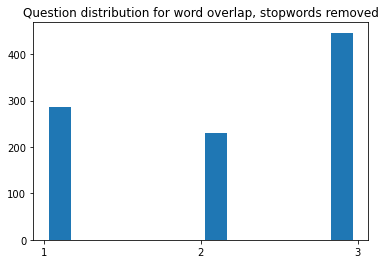

,context_stop_words,sent_stop_words,sent_original,q_stop_words,q_original,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,matching_sentences,matching_original_sentences,data
0,"[[visum, affärs-, konferensbesök], [om, ska, b...","[visum, tillstånd, resa, in, land, kortare, tid]","[visum, är, ett, tillstånd, för, att, resa, in...",[visum],"[vad, är, ett, visum]",1,5,[],[],"(2, 0, 1, 3, 6)","[visum tillstånd resa in land kortare tid, vis...",[visum är ett tillstånd för att resa in och va...,"{2: {'original_sent_words': ['visum', 'är', 'e..."
1,"[[eget, företag], [efter, beslut, beslutet, sk...","[ska, hämta, beslut, ta, pass]","[när, du, ska, hämta, ditt, beslut, ska, du, t...","[ska, ta, hämtar, beslut]","[vad, ska, du, ta, med, när, du, hämtar, ditt,...",3,4,[hämtar],[hämtar],"(2, 1, 9, 12)","[ska hämta beslut ta pass, efter beslut beslut...",[när du ska hämta ditt beslut ska du ta med di...,"{2: {'original_sent_words': ['när', 'du', 'ska..."
2,"[[utbytesdoktorander, intervju], [du, kommer, ...","[länge, gäller, tillståndet, uppehållstillstån...","[så, länge, gäller, tillståndet, ett, uppehåll...","[länge, gäller, uppehållstillstånd, besök, län...","[hur, länge, gäller, ett, uppehållstillstånd, ...",1,4,[],[],"(18, 4, 5, 19)",[länge gäller tillståndet uppehållstillstånd b...,[så länge gäller tillståndet ett uppehållstill...,"{18: {'original_sent_words': ['så', 'länge', '..."
3,"[[eget, företag], [när, tagit, emot, ansökan],...","[kortet, bevis, tillstånd, sverige, innehåller...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,3,[uppehållstillståndskort],[],"(8, 7, 10)",[kortet bevis tillstånd sverige innehåller bla...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '..."
4,"[[flytta, tillbaka, sverige], [så, ansöker, du...","[kortet, bevis, tillstånd, sverige, innehåller...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,5,[uppehållstillståndskort],[],"(8, 7, 10, 12, 20)",[kortet bevis tillstånd sverige innehåller bla...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '..."


In [253]:
# word overlap with stopwords removed
all_relevant_sentences_word_stop, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train)
df_word_stop = pd.DataFrame(all_relevant_sentences_word_stop)
# have to make copy!! otherwise it sorts the col in place in the df..
df_word_stop_copy = df_word_stop.copy()
overlap_values = df_word_stop_copy['overlap_class'].values

plot_question_type_stats(overlap_values, 'Question distribution for word overlap, stopwords removed')
df_word_stop.head()

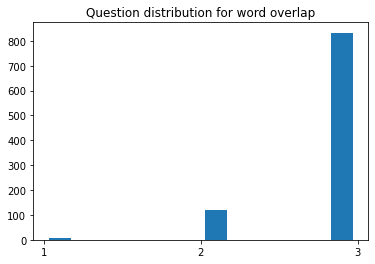

In [254]:
# word overlap with stopwords removed
all_relevant_sentences_word, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, False, False)
df_word = pd.DataFrame(all_relevant_sentences_word)
# have to make copy!! otherwise it sorts the col in place in the df..
df_word_copy = df_word.copy()
overlap_values = df_word_copy['overlap_class'].values

plot_question_type_stats(overlap_values, 'Question distribution for word overlap')

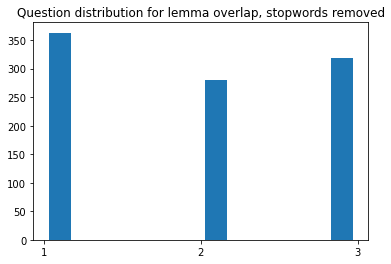

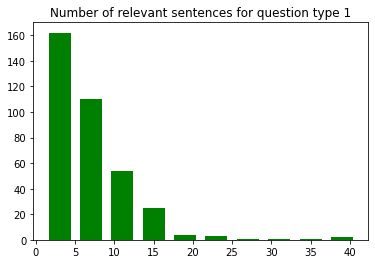

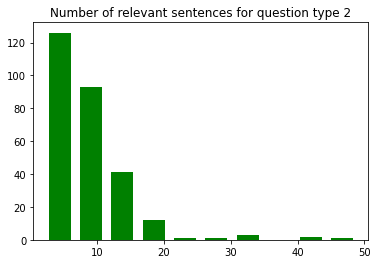

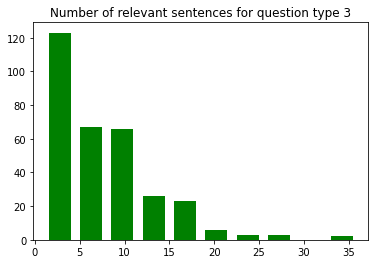

,context_stop_lemmas,sent_stop_lemmas,sent_original,q_stop_lemmas,q_original,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,matching_sentences,matching_original_sentences,data
0,"[[visa, affär, konferensbesök], [om, skola, be...","[visum, tillstånd, resa, in, land, kort, tid]","[visum, är, ett, tillstånd, för, att, resa, in...",[visum],"[vad, är, ett, visum]",1,5,[],[],"(2, 1, 3, 6, 7)","[visum tillstånd resa in land kort tid, om sko...",[visum är ett tillstånd för att resa in och va...,"{2: {'original_sent_words': ['visum', 'är', 'e..."
1,"[[egen, företag], [efter, beslut, skicka, amba...","[skola, hämta, beslut, ta, pass]","[när, du, ska, hämta, ditt, beslut, ska, du, t...","[skola, ta, hämta, beslut]","[vad, ska, du, ta, med, när, du, hämtar, ditt,...",1,6,[],[],"(2, 1, 6, 9, 11, 12)","[skola hämta beslut ta pass, efter beslut skic...",[när du ska hämta ditt beslut ska du ta med di...,"{2: {'original_sent_words': ['när', 'du', 'ska..."
2,"[[utbytesdoktorand, intervju], [du, komma, få,...","[länge, gälla, tillstånde, uppehållstillstånd,...","[så, länge, gäller, tillståndet, ett, uppehåll...","[länge, gälla, uppehållstillstånd, besök]","[hur, länge, gäller, ett, uppehållstillstånd, ...",1,4,[],[],"(18, 4, 5, 19)",[länge gälla tillstånde uppehållstillstånd bes...,[så länge gäller tillståndet ett uppehållstill...,"{18: {'original_sent_words': ['så', 'länge', '..."
3,"[[egen, företag], [när, ta, emot, ansökan], [o...","[kort, bevis, tillstånd, sverige, innehålla, b...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,3,[uppehållstillståndskort],[],"(8, 7, 10)",[kort bevis tillstånd sverige innehålla bland ...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '..."
4,"[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[kort, bevis, tillstånd, sverige, innehålla, b...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,5,[uppehållstillståndskort],[],"(8, 7, 10, 12, 20)",[kort bevis tillstånd sverige innehålla bland ...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '..."


In [255]:
# lemma overlap with stopwords removed
all_relevant_sentences_lemma_stop, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, True, True)
df_lemma_stop = pd.DataFrame(all_relevant_sentences_lemma_stop)
# have to make copy!! otherwise it sorts the col in place in the df..
df_lemma_stop_copy = df_lemma_stop.copy()
overlap_values = df_lemma_stop_copy['overlap_class'].values

df_lemma_stop_class_1 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 1]
df_lemma_stop_class_2 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 2]
df_lemma_stop_class_3 = df_lemma_stop.loc[df_lemma_stop['overlap_class'] == 3]
# df_missing = df_lemma_stop.loc[df_lemma_stop['missing_words_context'] == 0]

plot_question_type_stats(overlap_values, 'Question distribution for lemma overlap, stopwords removed')

# plot the number of relevant sentences for each of the question types
plot_question_type_stats_num(df_lemma_stop_class_1['num_overlap_sentences'].values, 'Number of relevant sentences for question type 1')
plot_question_type_stats_num(df_lemma_stop_class_2['num_overlap_sentences'].values, 'Number of relevant sentences for question type 2')
plot_question_type_stats_num(df_lemma_stop_class_3['num_overlap_sentences'].values, 'Number of relevant sentences for question type 3')
df_lemma_stop.head()


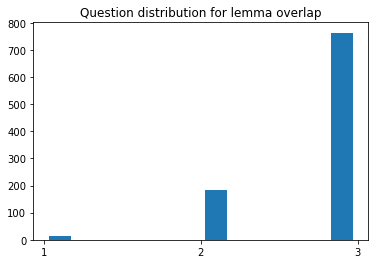

In [256]:
# lemma overlap with stopwords removed
all_relevant_sentences_lemma, all_relevant_sentence_idxs = collect_relevant_sentences(df_train, df_dp_overlap_train, False, True)
df_lemma = pd.DataFrame(all_relevant_sentences_lemma)
# have to make copy!! otherwise it sorts the col in place in the df..
df_lemma_copy = df_lemma.copy()
overlap_values = df_lemma_copy['overlap_class'].values

# df_class_1 = df_lemma.loc[df_lemma['overlap_class'] == 1]
# df_class_2 = df_lemma.loc[df_lemma['overlap_class'] == 2]
# df_class_3 = df_lemma.loc[df_lemma['overlap_class'] == 3]

plot_question_type_stats(overlap_values, 'Question distribution for lemma overlap')

In [257]:
# print some examples from each of the data classes:
def save_sentence_statistics(filename, df, type, title):
    with open(filename, 'w') as out:
        out.write(title+ '\n')
        for index, row in df.iterrows():
            out.write('-------------------'+ '\n')
            out.write('question, parsed: ' + ' '.join(row['q_'+type]) + '\n')
            out.write('question, original: ' + ' '.join(row['q_original']) + '\n')
            out.write('missing words context: ' + ' '.join(row['missing_words_context']) + '\n')
            out.write('sentence with answer, parsed: ' + ' '.join(row['sent_'+type]) + '\n')
            out.write('sentence with answer, original: ' + ' '.join(row['sent_original']) + '\n')
            out.write('overlap class: ' + str(row['overlap_class']) + '\n')
            relevant_sentences = row['matching_original_sentences']
            out.write('matching sentences, original: \n')
            for sent in relevant_sentences:
                out.write(sent + '\n')

In [258]:
save_sentence_statistics('figures/relevant_sentences/relevant-sentences-lemma-stop.txt', df_lemma_stop, 'stop_lemmas', 'Relevant sentences for questions in dataset. Statistics for lemma with stopwords removed.')

In [259]:
save_sentence_statistics('figures/relevant_sentences/relevant-sentences-word-stop.txt', df_word_stop, 'stop_words', 'Relevant sentences for questions in dataset. Statistics for words with stopwords removed.')

In [260]:
# load the tf-idf dataframe
df_tf_idf_lemma_stop = pd.read_pickle("./data_frames/tf-idf/df_tf_idf_lemma_stop.pkl")
df_tf_idf_lemma_stop.head()

,000,0000,010,011,0128,01454,03,05,06,06975,...,övervakning,övervakningsarbete,överväga,övervägande,övning,övningsanläggning,övningskörning,övningsverksamhet,övrig,övrigt
0,0.06595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041624,0.0
1,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [261]:
# rank relevant sentences based on tf-idf
def rank_matching_sentences(df):
    ranked_sentences = []
    ranked_original_sentences = []
    ranked_sentence_ids = []
    for index, row in df.iterrows():
        matching_sentence_scores = []
        matching_sentences = row['matching_sentences']
        matching_original_sentences = row['matching_original_sentences']
        matching_sentence_ids = row['matching_sentence_ids']
        q_lemmas = row['q_stop_lemmas']
        tf_idf = df_tf_idf_lemma_stop.iloc[index]
        for sent in matching_sentences:
            sentence_score = 0
            for w in q_lemmas:
                if w in tf_idf:
                    word_score = tf_idf[w]
                    # print('word_score: ', word_score)
                    if w in sent:
                        sentence_score += word_score
                else:
                    print('word is missing in tf-idf table! ', w)
            matching_sentence_scores.append(sentence_score)
        # sort the sentences based on score
        
        matching_sentence_scores, matching_sentences, matching_sentence_ids, matching_original_sentences = zip(*sorted(zip(matching_sentence_scores, matching_sentences, matching_sentence_ids, matching_original_sentences), reverse=True))
        # print('sent scores: ', matching_sentence_scores)
        # print('sentences: ', matching_sentences)
        ranked_sentences.append(matching_sentences)
        ranked_sentence_ids.append(matching_sentence_ids)
        ranked_original_sentences.append(matching_original_sentences)
    return ranked_sentences, ranked_sentence_ids, ranked_original_sentences
        
            
        
        

ranked_sentences, ranked_sentence_ids, ranked_original_sentences = rank_matching_sentences(df_lemma_stop)
df_lemma_stop['ranked_matching_sentences'] = ranked_sentences
df_lemma_stop['ranked_matching_sentence_ids'] = ranked_sentence_ids
df_lemma_stop['ranked_matching_original_sentences'] = ranked_original_sentences
df_lemma_stop.head()


word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  ,
word is missing in tf-idf table!  tillsynsinst
word is missing in tf-idf table!  tillsynsinst
word is missing in tf-idf table!  felsatt
word is missing in tf-idf table!  felsatt
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  konferensbord
word is missing in tf-idf table!  vemvilka
word is missing in tf-i

,context_stop_lemmas,sent_stop_lemmas,sent_original,q_stop_lemmas,q_original,overlap_class,num_overlap_sentences,missing_words_sent,missing_words_context,matching_sentence_ids,matching_sentences,matching_original_sentences,data,ranked_matching_sentences,ranked_matching_sentence_ids,ranked_matching_original_sentences
0,"[[visa, affär, konferensbesök], [om, skola, be...","[visum, tillstånd, resa, in, land, kort, tid]","[visum, är, ett, tillstånd, för, att, resa, in...",[visum],"[vad, är, ett, visum]",1,5,[],[],"(2, 1, 3, 6, 7)","[visum tillstånd resa in land kort tid, om sko...",[visum är ett tillstånd för att resa in och va...,"{2: {'original_sent_words': ['visum', 'är', 'e...","(visum tillstånd resa in land kort tid, pass g...","(2, 7, 1, 6, 3)",(visum är ett tillstånd för att resa in och va...
1,"[[egen, företag], [efter, beslut, skicka, amba...","[skola, hämta, beslut, ta, pass]","[när, du, ska, hämta, ditt, beslut, ska, du, t...","[skola, ta, hämta, beslut]","[vad, ska, du, ta, med, när, du, hämtar, ditt,...",1,6,[],[],"(2, 1, 6, 9, 11, 12)","[skola hämta beslut ta pass, efter beslut skic...",[när du ska hämta ditt beslut ska du ta med di...,"{2: {'original_sent_words': ['när', 'du', 'ska...","(skola hämta beslut ta pass, uppehållstillstån...","(2, 6, 9, 11, 1, 12)",(när du ska hämta ditt beslut ska du ta med di...
2,"[[utbytesdoktorand, intervju], [du, komma, få,...","[länge, gälla, tillstånde, uppehållstillstånd,...","[så, länge, gäller, tillståndet, ett, uppehåll...","[länge, gälla, uppehållstillstånd, besök]","[hur, länge, gäller, ett, uppehållstillstånd, ...",1,4,[],[],"(18, 4, 5, 19)",[länge gälla tillstånde uppehållstillstånd bes...,[så länge gäller tillståndet ett uppehållstill...,"{18: {'original_sent_words': ['så', 'länge', '...",(länge gälla tillstånde uppehållstillstånd bes...,"(18, 19, 4, 5)",(så länge gäller tillståndet ett uppehållstill...
3,"[[egen, företag], [när, ta, emot, ansökan], [o...","[kort, bevis, tillstånd, sverige, innehålla, b...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,3,[uppehållstillståndskort],[],"(8, 7, 10)",[kort bevis tillstånd sverige innehålla bland ...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '...",(om få tillstånd mycket tre månad uppehållstil...,"(7, 10, 8)",(om du får tillstånd för mer än tre månader få...
4,"[[flytta, tillbaka, Sverige], [så, ansöka, du,...","[kort, bevis, tillstånd, sverige, innehålla, b...","[kortet, är, ett, bevis, på, att, du, har, til...",[uppehållstillståndskort],"[vad, är, ett, uppehållstillståndskort]",2,5,[uppehållstillståndskort],[],"(8, 7, 10, 12, 20)",[kort bevis tillstånd sverige innehålla bland ...,[kortet är ett bevis på att du har tillstånd a...,"{8: {'original_sent_words': ['kortet', 'är', '...",(om få tillstånd mycket tre månad uppehållstil...,"(7, 20, 12, 10, 8)",(om du får tillstånd för mer än tre månader få...


In [262]:
# compare sorted / unsorted relevant sentences
def save_ranked_sentence_statistics(filename, df, type, title):
    with open(filename, 'w') as out:
        out.write(title+ '\n')
        for index, row in df.iterrows():
            out.write('-------------------'+ '\n')
            out.write('overlap class: ' + str(row['overlap_class']) + '\n')
            out.write('question, parsed: ' + ' '.join(row['q_'+type]) + '\n')
            out.write('question, original: ' + ' '.join(row['q_original']) + '\n')
            out.write('missing words context: ' + ' '.join(row['missing_words_context']) + '\n')
            out.write('sentence with answer, parsed: ' + ' '.join(row['sent_'+type]) + '\n')
            out.write('sentence with answer, original: ' + ' '.join(row['sent_original']) + '\n')
            relevant_sentences = row['matching_original_sentences']
            ranked_relevant_sentences = row['ranked_matching_original_sentences']
            out.write('top 3 matching sentences: \n')
            max = 3
            if len(relevant_sentences) < max:
                max = len(relevant_sentences)
            for sent in relevant_sentences[:max]:
                out.write(sent + '\n')
            out.write('top RANKED matching sentences: \n')
            for sent in ranked_relevant_sentences[:max]:
                out.write(sent + '\n')

In [263]:
save_ranked_sentence_statistics('figures/relevant_sentences/ranked-relevant-sentences-lemma-stop.txt', df_lemma_stop, 'stop_lemmas', 'Ranked relevant sentences for questions in dataset. Statistics for lemma with stopwords removed.')

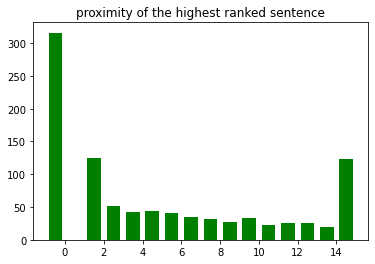

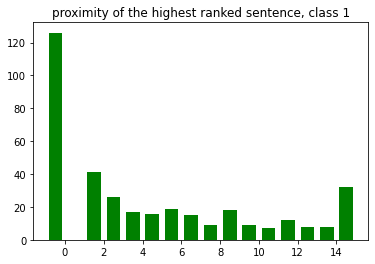

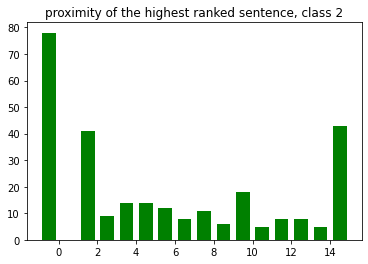

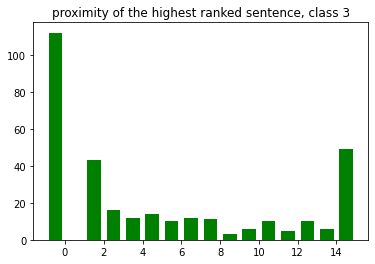

In [266]:
# create some statistics for how close to the sentence containing the answer, the relevant sentences are
def extract_proximity_of_ranked_relevant_sentences(df):
    top_ranked_sentence_diff = []
    for index, row in df.iterrows():
        matching_sent_ids = list(row['matching_sentence_ids'])
        ranked_matching_sent_ids = list(row['matching_sentence_ids'])
        sent_with_ans = matching_sent_ids[0]
        top_ranked_sent = ranked_matching_sent_ids[0]
        if sent_with_ans == top_ranked_sent and len(ranked_matching_sent_ids) > 1:
            top_ranked_sent = ranked_matching_sent_ids[1]
        else: # if there are no other sentences than the sentence containing the answer
            top_ranked_sent = None
        diff = -1
        if top_ranked_sent:
            diff = np.abs(sent_with_ans - top_ranked_sent)
            if diff > 15:
                diff = 15
        top_ranked_sentence_diff.append(diff)
    return top_ranked_sentence_diff

diff_arr = extract_proximity_of_ranked_relevant_sentences(df_lemma_stop)
plot_question_type_stats_num(diff_arr, 'proximity of the highest ranked sentence', 16)

diff_arr = extract_proximity_of_ranked_relevant_sentences(df_lemma_stop_class_1)
plot_question_type_stats_num(diff_arr, 'proximity of the highest ranked sentence, class 1', 16)

diff_arr = extract_proximity_of_ranked_relevant_sentences(df_lemma_stop_class_2)
plot_question_type_stats_num(diff_arr, 'proximity of the highest ranked sentence, class 2', 16)

diff_arr = extract_proximity_of_ranked_relevant_sentences(df_lemma_stop_class_3)
plot_question_type_stats_num(diff_arr, 'proximity of the highest ranked sentence, class 3', 16)

